# i. Perkenalan

----------------------------------------------

NAMA : MICHAEL WILBERT PURADISASTRA

BATCH : RMT-037

Program ini dirancang untuk membantu tim Data Scientist dalam membangun model klasifikasi yang dapat membedakan antara gambar **anime** dan **cartoon**. Model ini diharapkan dapat digunakan oleh tim kreatif, tim pemasaran, atau platform streaming untuk mengelompokkan konten visual berdasarkan gaya animasinya. Dataset yang digunakan adalah kumpulan gambar dari kategori **anime** dan **cartoon** yang diperoleh dari repositori *kaggle*, yang telah diproses untuk memastikan kualitas data yang optimal untuk pelatihan model.

----------------------------------------------

# ii. Import Libraries

In [45]:
# Downgrade version of TensorFlow and tf-keras

!pip install -q --upgrade "tensorflow<2.16" "tf-keras<2.16"

In [46]:
!pip install split-folders

In [47]:
# Import libraries

# Standard libraries
import os
import cv2
import glob
import random
import shutil
import warnings
warnings.filterwarnings('ignore')

# Data processing and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

# Sklearn utilities
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Google Colab utilities
from google.colab import drive, files

# Split folder utility
import splitfolders

# Check TensorFlow version
print(tf.__version__)

2.15.1


# iii. Data Loading

In [48]:
%%time
# Download Dataset
# Source dataset : https://www.kaggle.com/datasets/kanakmittal/anime-and-cartoon-image-classification

!kaggle datasets download kanakmittal/anime-and-cartoon-image-classification

Dataset URL: https://www.kaggle.com/datasets/kanakmittal/anime-and-cartoon-image-classification
License(s): copyright-authors
anime-and-cartoon-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
CPU times: user 11.5 ms, sys: 2.87 ms, total: 14.3 ms
Wall time: 1.01 s


In [49]:
# Every dataset that downloaded from Kaggle is in format `.zip`. So, we must unzip it before we can using the dataset.

!unzip -qq ./anime-and-cartoon-image-classification.zip

# iv. Exploratory Data Analysis (EDA)

In [50]:
# Path dataset
dataset_path = '/content/Training Data'

# Hitung total file sebelum memproses
total_files = sum([len(files) for _, _, files in os.walk(dataset_path)])
print(f"Total files found before processing: {total_files}")

# Loop setiap folder kelas
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        # Rekursif ke semua subfolder
        for root, _, files in os.walk(class_path):
            for file in files:
                file_path = os.path.join(root, file)
                new_file_path = os.path.join(class_path, file)

                # Tambahkan sufiks jika file sudah ada
                counter = 1
                while os.path.exists(new_file_path):
                    file_name, file_ext = os.path.splitext(file)
                    new_file_path = os.path.join(class_path, f"{file_name}_copy{counter}{file_ext}")
                    counter += 1

                shutil.move(file_path, new_file_path)

        # Hapus subfolder kosong setelah semua file dipindahkan
        for root, dirs, _ in os.walk(class_path, topdown=False):
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                if not os.listdir(dir_path):  # Jika folder kosong
                    os.rmdir(dir_path)

# Hitung total file setelah memproses
total_files_after = sum([len(files) for _, _, files in os.walk(dataset_path)])
print(f"Total files found after processing: {total_files_after}")

Total files found before processing: 17784
Total files found after processing: 17784


Dataset yang digunakan diambil dari Kaggle, berupa sebuah folder utama bernama **"Training Data"**. Di dalam folder tersebut terdapat dua subfolder, yaitu **"Anime"** dan **"Cartoon"**. Setiap subfolder ini berisi kumpulan folder lain yang diberi nama sesuai dengan judul-judul kategori tersebut.

Di dalam setiap folder kategori (judul), terdapat file gambar dalam format **.jpg** dan **.png** dengan total keseluruhan **8,892 gambar**. Untuk mempermudah proses analisis dan pelatihan model, semua file gambar dari setiap folder kategori dipindahkan langsung ke subfolder **"Anime"** dan **"Cartoon"** masing-masing. Setelah proses pemindahan, dilakukan pengecekan untuk memastikan bahwa jumlah total file gambar tetap konsisten, yaitu **8,892 gambar**, tanpa ada kehilangan data selama proses pemindahan.

Langkah ini bertujuan untuk menyederhanakan struktur dataset sehingga lebih mudah diakses oleh generator data selama proses pelatihan dan validasi model.

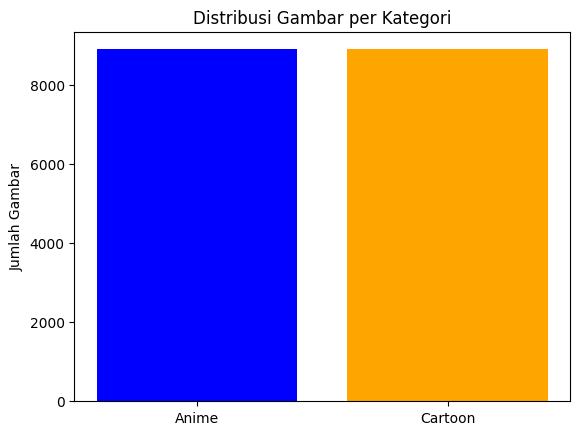

In [51]:
# Membuat plot distribusi data
anime_images = len(os.listdir('/content/Training Data/Anime'))
cartoon_images = len(os.listdir('/content/Training Data/Cartoon'))

data_distribution = {'Anime': anime_images, 'Cartoon': cartoon_images}

plt.bar(data_distribution.keys(), data_distribution.values(), color=['blue', 'orange'])
plt.title('Distribusi Gambar per Kategori')
plt.ylabel('Jumlah Gambar')
plt.show()


Kedua kategori memiliki jumlah gambar yang hampir seimbang, dengan sedikit lebih banyak gambar pada kategori Anime dibandingkan dengan Cartoon. Distribusi data yang seimbang ini penting karena membantu mencegah bias model terhadap salah satu kategori, sehingga model dapat belajar dengan baik dan menghasilkan prediksi yang lebih akurat pada kedua kelas.

In [52]:
# Memeriksa format file
anime_formats = [f.split('.')[-1] for f in os.listdir('/content/Training Data/Anime')]
cartoon_formats = [f.split('.')[-1] for f in os.listdir('/content/Training Data/Cartoon')]

print(f"Format file di Anime: {set(anime_formats)}")
print(f"Format file di Cartoon: {set(cartoon_formats)}")


Format file di Anime: {'jpg', 'png'}
Format file di Cartoon: {'jpg', 'png'}


In [53]:
# Memeriksa dimensi gambar

anime_path = '/content/Training Data/Anime'
cartoon_path = '/content/Training Data/Cartoon'

def check_image_sizes(folder_path):
    dimensions = []
    for img_file in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, img_file))
        if img is not None:
            dimensions.append(img.shape[:2])  # Height, Width
    return dimensions

anime_sizes = check_image_sizes(anime_path)
cartoon_sizes = check_image_sizes(cartoon_path)

print(f"Dimensi rata-rata Anime: {np.mean(anime_sizes, axis=0)}")
print(f"Dimensi rata-rata Cartoon: {np.mean(cartoon_sizes, axis=0)}")


Dimensi rata-rata Anime: [186.98583315 245.22779402]
Dimensi rata-rata Cartoon: [186.75388076 245.34038245]


Hasil analisis menunjukkan bahwa file gambar dalam kategori Anime dan Cartoon memiliki format yang seragam, yaitu .jpg dan .png, sehingga memudahkan proses pra-pemrosesan dan pelatihan model. Dari sisi dimensi gambar, rata-rata gambar pada kedua kategori memiliki ukuran yang hampir sama, yaitu sekitar 186 x 245 piksel, dengan sedikit perbedaan pada lebar gambar. Dimensi yang konsisten ini menunjukkan bahwa dataset sudah cukup bersih dan terstruktur, sehingga tidak memerlukan banyak penyesuaian tambahan sebelum digunakan dalam pelatihan model klasifikasi. Namun, ukuran ini akan diubah menjadi 380 x 380 selama preprocessing untuk disesuaikan dengan kebutuhan model EfficientNetB7.

# v. Feature Engineering

In [54]:
input_folder = '/content/Training Data'
output_folder = '/content/Dataset'
splitfolders.ratio(input_folder, output=output_folder, seed=13, ratio=(.8, .2))

Copying files: 17784 files [00:06, 2868.29 files/s]


In [55]:
#Define path

train_path = '/content/Dataset/train'
test_path = '/content/Dataset/val'

In [56]:
#Check how many data in each set

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Number of {label} data : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Number of Anime data : 7808
Number of Cartoon data : 7795

Test Path
Number of Anime data : 2494
Number of Cartoon data : 2477



Dataset dibagi menjadi dua bagian, yaitu train dan test, dengan tujuan untuk mempersiapkan data untuk proses pelatihan, validasi, dan pengujian model. Pembagian dilakukan dengan rasio 1:4 (0.2:0.8), di mana 80% data akan digunakan untuk train_path (yang nantinya akan dibagi lagi menjadi train dan val), dan 20% data akan digunakan untuk test_path (sebagai data pengujian).

Setelah pembagian dilakukan, dilakukan pengecekan untuk memastikan bahwa jumlah data tetap konsisten dan distribusi antara kategori Anime dan Cartoon dalam train_path dan test_path tetap seimbang. Hal ini penting untuk menghindari bias pada salah satu kategori selama proses pelatihan dan evaluasi model.

In [57]:
# Function to visualize the first 5 images from each class

def visualize_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()


Class :  Anime


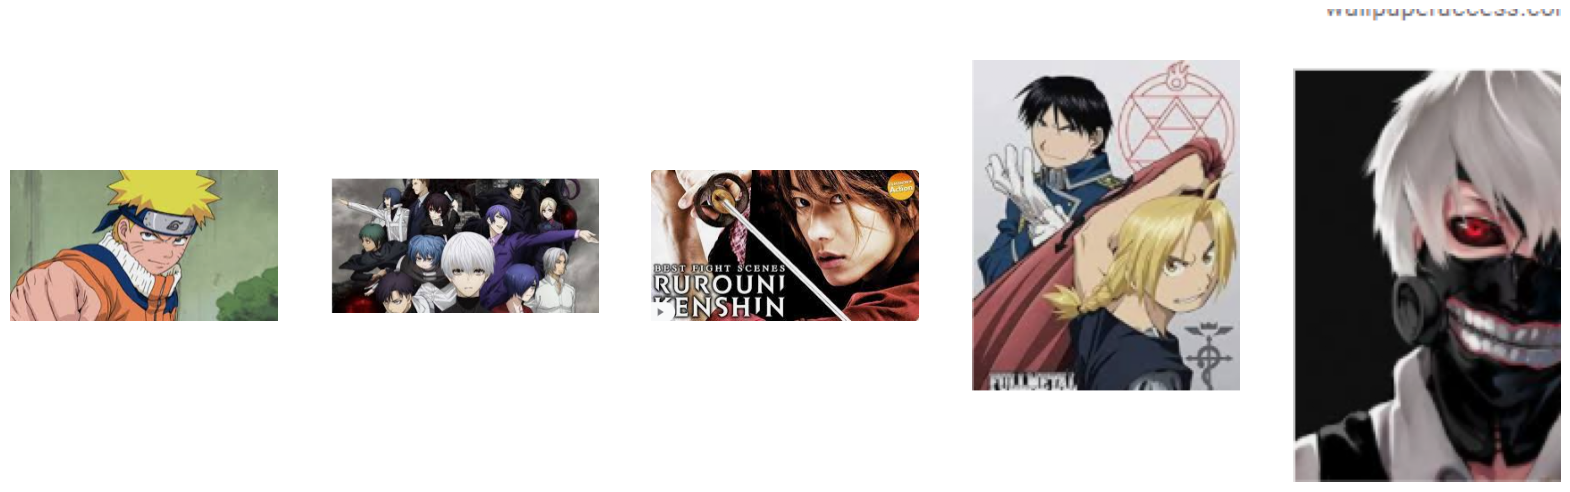

Class :  Cartoon


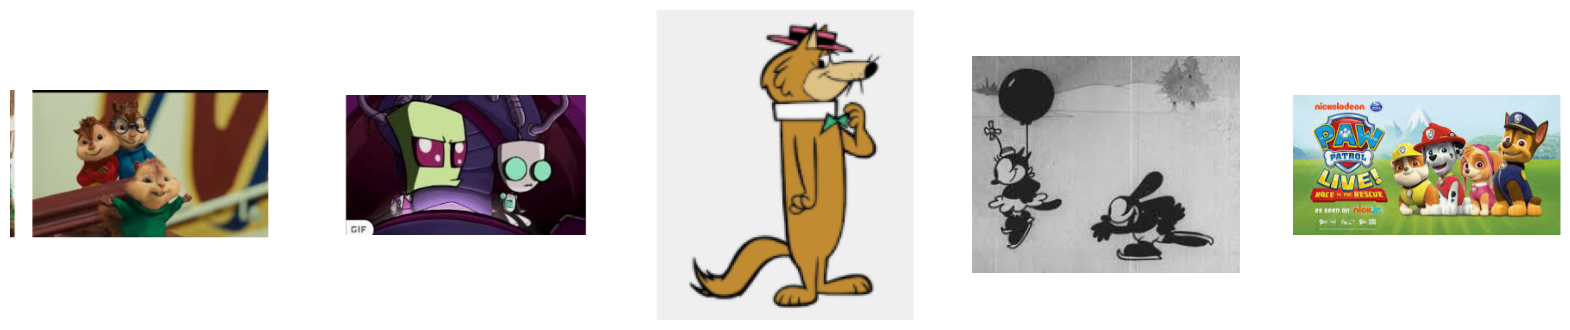

In [58]:
# Visualization of train_path

visualize_images(train_path)

Class :  Anime


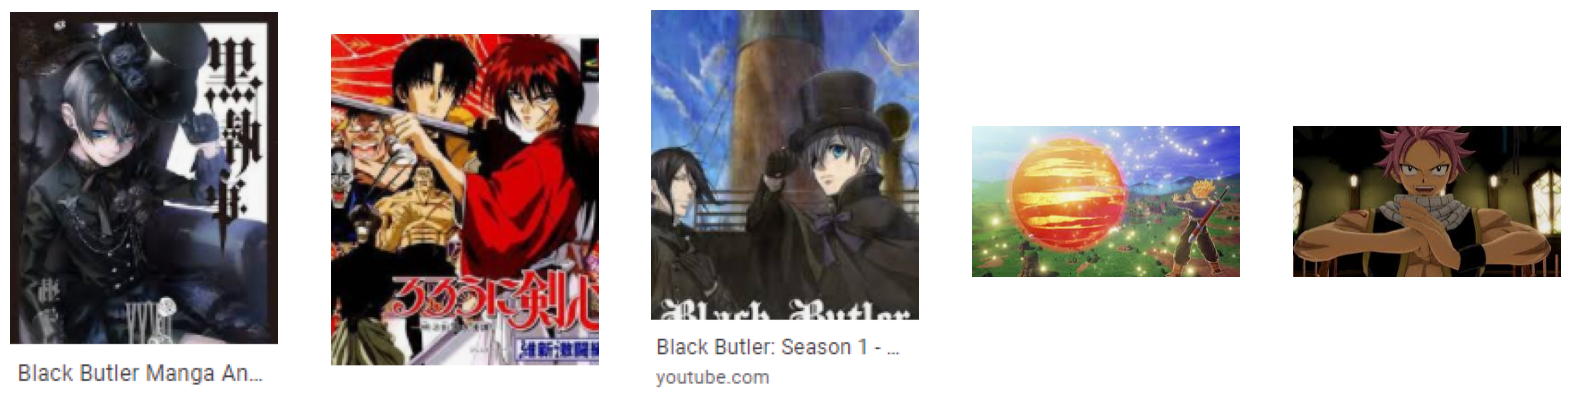

Class :  Cartoon


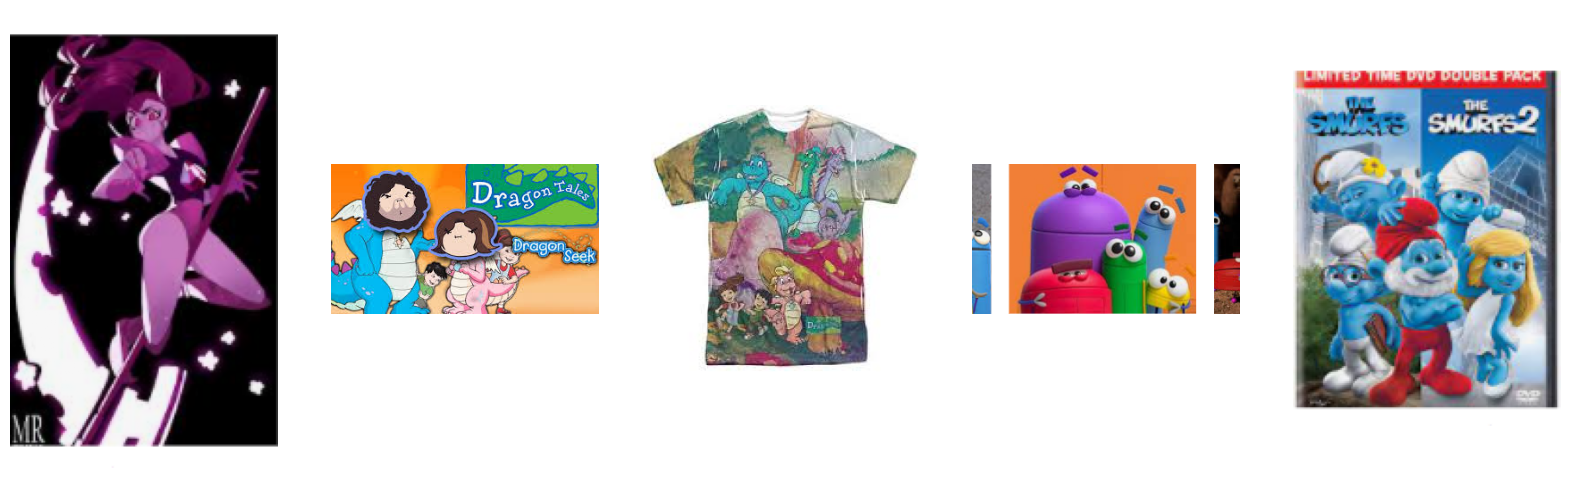

In [59]:
# Visualization of `test_path`

visualize_images(test_path)

Untuk memastikan bahwa file-file dalam setiap folder kategori Anime dan Cartoon sudah benar sesuai dengan klasifikasinya, dilakukan pengecekan data manual untuk memvalidasi bahwa setiap file gambar sesuai dengan kategori tempatnya berada. Berikut cara yang digunakan:Secara acak dipilih 5 gambar dari folder Anime dan Cartoon, kemudian ditampilkan. Gambar-gambar ini diverifikasi secara visual untuk memastikan kesesuaiannya dengan kategori masing-masing.

# vi. CNN Training ((Sequential API/Functional API))

In [60]:
# Define hyperparameters

img_height= 380
img_width= 380
batch_size= 64

Pemilihan ukuran gambar 380 x 380 memiliki beberapa alasan teknis yang relevan, terutama dalam konteks penggunaan model EfficientNetB7, yang merupakan model pretrained yang diambil dari tensorflow.keras.applications.

Kesesuaian dengan Model Pretrained:

EfficientNetB7 dirancang untuk bekerja optimal dengan ukuran gambar tertentu. Ukuran default yang digunakan untuk EfficientNetB7 adalah 380 x 380, yang memastikan model pretrained dapat memanfaatkan representasi fitur secara maksimal tanpa perlu interpolasi atau downscaling yang signifikan. Dengan batch size 64, gradien yang dihitung lebih stabil, membantu model belajar lebih baik selama backpropagation.

In [61]:
# ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=20,
                                    zoom_range=0.05,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.05,
                                    horizontal_flip=True,
                                    validation_split=0.4,
                                    preprocessing_function=preprocess_input
                                    )
test_datagen = ImageDataGenerator(rescale=1./255.)

Augmentasi ini mencakup transformasi gambar seperti rotasi hingga 20 derajat (rotation_range), zoom kecil hingga 5% (zoom_range), pergeseran horizontal dan vertikal sebesar 5% (width_shift_range, height_shift_range), transformasi geser (shear_range), dan flipping secara horizontal (horizontal_flip). Selain itu, validation_split digunakan untuk membagi dataset menjadi bagian pelatihan (training) dan validasi (validation), dengan proporsi 60% untuk pelatihan dan 40% untuk validasi. Fungsi preprocessing_function=preprocess_input diterapkan untuk menyesuaikan data agar sesuai dengan standar model, memastikan data di-skala dan distandardisasi dengan benar untuk optimasi pelatihan.

In [62]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='binary',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=13)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='binary',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=13)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=13)

Found 9362 images belonging to 2 classes.
Found 6241 images belonging to 2 classes.
Found 4971 images belonging to 2 classes.


In [63]:
# Show labels

train_set.class_indices

{'Anime': 0, 'Cartoon': 1}

## vi.1. Model Definition

Model ini menggunakan Convolutional Neural Network (CNN) dengan pendekatan Sequential API. CNN dipilih karena sangat efektif untuk tugas klasifikasi gambar seperti membedakan antara Anime dan Cartoon, karena kemampuannya untuk menangkap fitur visual seperti pola, tekstur, dan warna dari gambar. Dengan menggunakan beberapa lapisan konvolusi (Conv2D) dan pooling (MaxPooling2D), model dapat belajar representasi hierarkis dari gambar, dari fitur sederhana hingga kompleks.

In [64]:
# Clear session

seed = 13
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Model menggunakan filter dengan ukuran 32, 64, dan 128 pada tiga lapisan Conv2D untuk menangkap fitur visual dengan kompleksitas meningkat. Kernel size (3, 3) dipilih karena memberikan keseimbangan antara detail dan efisiensi komputasi, sementara Dropout 0.5 diterapkan untuk mencegah overfitting dengan mematikan 50% neuron secara acak. Optimizer Adam digunakan karena mampu menyesuaikan learning rate secara dinamis selama pelatihan, dan binary crossentropy digunakan sebagai fungsi loss karena sesuai untuk tugas klasifikasi biner.

In [65]:
# Create Sequential API model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output untuk binary classification

#Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 378, 378, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 189, 189, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 187, 187, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 93, 93, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 91, 91, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 45, 45, 128)       0

Metrik accuracy digunakan untuk mengevaluasi performa model dengan cara mengukur persentase prediksi yang benar terhadap total data. Metrik ini sederhana dan relevan untuk tugas klasifikasi biner seperti ini, di mana kelas memiliki distribusi yang relatif seimbang setelah penanganan ketidakseimbangan data.

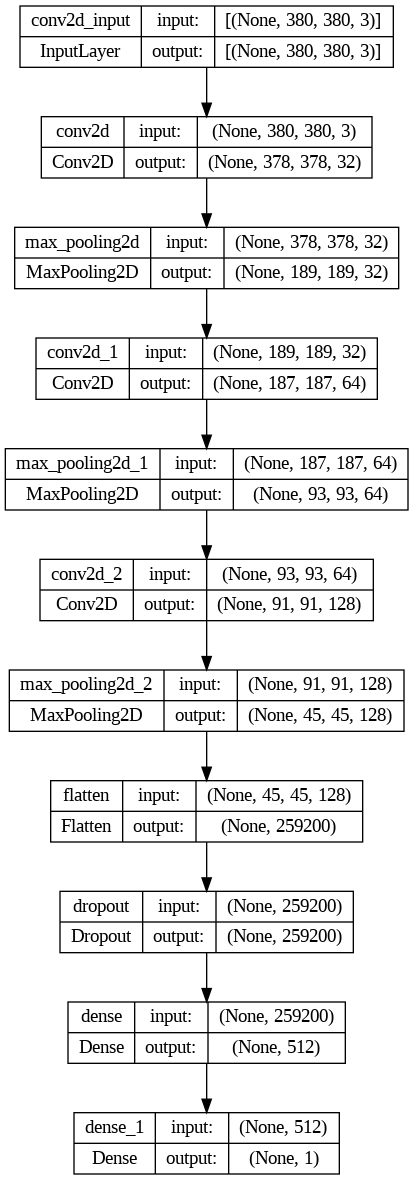

In [66]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

## vi.2. Model Training

In [67]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)

# Convert to dictionary
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)


Class Weights: {0: 0.9991462113127001, 1: 1.0008552490912979}


In [68]:
# Train the model

%%time
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_set,
    epochs=20,
    validation_data=val_set,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/20
147/147 [==============================] - 501s 3s/step - loss: 0.8663 - accuracy: 0.6992 - val_loss: 0.6184 - val_accuracy: 0.7028
Epoch 2/20
147/147 [==============================] - 496s 3s/step - loss: 0.4957 - accuracy: 0.7716 - val_loss: 0.5827 - val_accuracy: 0.7278
Epoch 3/20
147/147 [==============================] - 496s 3s/step - loss: 0.4622 - accuracy: 0.7882 - val_loss: 0.5941 - val_accuracy: 0.7209
Epoch 4/20
147/147 [==============================] - 496s 3s/step - loss: 0.4297 - accuracy: 0.8069 - val_loss: 0.5155 - val_accuracy: 0.7629
Epoch 5/20
147/147 [==============================] - 496s 3s/step - loss: 0.4114 - accuracy: 0.8159 - val_loss: 0.5027 - val_accuracy: 0.7641
Epoch 6/20
147/147 [==============================] - 497s 3s/step - loss: 0.3845 - accuracy: 0.8349 - val_loss: 0.5081 - val_accuracy: 0.7601
Epoch 7/20
147/147 [==============================] - 496s 3s/step - loss: 0.3846 - accuracy: 0.8329 - val_loss: 0.5498 - val_accuracy: 0.7645

## vi.3. Model Evaluation

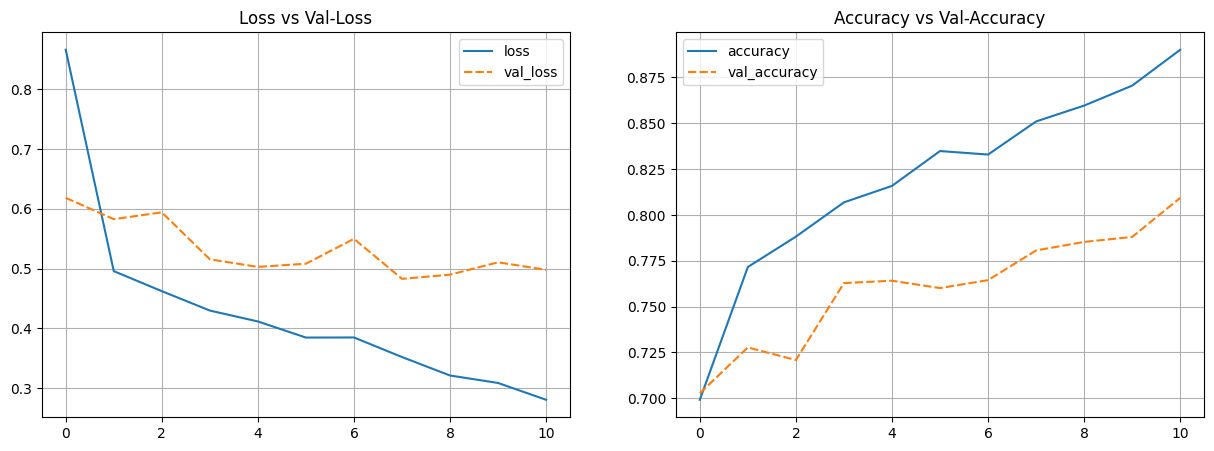

In [69]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Visualisasi Performa Pelatihan
a. Grafik Loss vs Val-Loss (Kiri):


*   Train Loss: Menurun secara konsisten, menunjukkan bahwa model berhasil belajar dari data pelatihan.
*   Val Loss: Awalnya menurun, tetapi kemudian mulai meningkat setelah beberapa epoch terakhir, menandakan tanda awal overfitting.
*   Interpretasi: Model mempelajari data pelatihan dengan baik, tetapi mulai kehilangan kemampuan untuk generalisasi pada data validasi.

b. Grafik Accuracy vs Val-Accuracy (Kanan):
*   Train Accuracy: Meningkat secara stabil, menunjukkan bahwa model semakin akurat pada data pelatihan.
*   Val Accuracy: Mengalami fluktuasi, tetapi stagnan di sekitar 70-75%. Hal ini menunjukkan bahwa model kesulitan meningkatkan performa pada data validasi setelah titik tertentu.

In [70]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model.predict_generator(test_set)

## Get class with maximum probability
y_pred_class = (y_pred_prob > 0.5).astype(int)

## Display Classification Report
print(classification_report(
    test_set.classes,  # Ground truth labels
    y_pred_class,      # Predicted labels
    target_names=list(test_set.class_indices.keys())  # Nama kelas
))


              precision    recall  f1-score   support

       Anime       0.81      0.87      0.84      2494
     Cartoon       0.86      0.80      0.83      2477

    accuracy                           0.83      4971
   macro avg       0.83      0.83      0.83      4971
weighted avg       0.83      0.83      0.83      4971



Anime
*   Precision: 0.81, menunjukkan bahwa dari semua prediksi Anime, 81% benar.
*   Recall: 0.87, artinya model berhasil menangkap 87% dari data Anime yang sebenarnya.
*   F1-Score: 0.84, memberikan keseimbangan antara precision dan recall.

Cartoon
* Precision: 0.86, menunjukkan bahwa dari semua prediksi Cartoon, 86% benar.
* Recall: 0.80, artinya model menangkap 80% dari data Cartoon yang sebenarnya.
* F1-Score: 0.83, menunjukkan performa yang cukup baik untuk kelas ini.

Akurasi Keseluruhan:
Akurasi model pada data test adalah 83%, menunjukkan bahwa model cukup baik dalam membedakan antara Anime dan Cartoon.

Macro Avg & Weighted Avg:

Macro average memberikan rata-rata yang sama untuk kedua kelas, sedangkan weighted average memberikan bobot berdasarkan jumlah data di setiap kelas. Keduanya menunjukkan nilai yang sama, yaitu 83%.

Analisis dan Insight
1. Overfitting:

Peningkatan pada val loss yang tidak diikuti dengan peningkatan val accuracy menunjukkan tanda awal overfitting, di mana model terlalu fokus pada data pelatihan.
2. Kinerja pada Kelas:

Model menunjukkan performa yang cukup seimbang antara kedua kelas (Anime dan Cartoon), meskipun recall untuk kelas Cartoon lebih rendah dibandingkan dengan kelas Anime.
3. Akurasi Keseluruhan:

Akurasi 77% menunjukkan bahwa model cukup baik, tetapi masih ada ruang untuk perbaikan, terutama untuk meningkatkan generalisasi pada data validasi dan test.

# vii. CNN Improvement (Sequential API/Functional API)

In [71]:
# Define hyperparameters

img_height= 380
img_width= 380
batch_size= 64

In [72]:
# Download pretrained model

pretrained_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))
pretrained_model.trainable = False

In [73]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    validation_split=0.4,
    preprocessing_function=preprocess_input
)

# Train set
train_set_tl = train_datagen_tl.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    class_mode='binary',
    subset='training',
    batch_size=batch_size,
    shuffle=True,
    seed=13
)

# Validation set
val_set_tl = train_datagen_tl.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    class_mode='binary',
    subset='validation',
    batch_size=batch_size,
    shuffle=False,
    seed=13
)

# Test set
test_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_set_tl = test_datagen_tl.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False,
    seed=13
)


Found 9362 images belonging to 2 classes.
Found 6241 images belonging to 2 classes.
Found 4971 images belonging to 2 classes.


EfficientNetB7 dipilih karena menawarkan kombinasi optimal antara akurasi tinggi dan efisiensi komputasi melalui pendekatan compound scaling, yang mengatur depth, width, dan resolution secara proporsional. Model ini menggunakan pretrained weights dari ImageNet, memungkinkan transfer learning untuk menangkap pola visual dasar seperti garis dan tekstur, sehingga mempersingkat waktu pelatihan dan meningkatkan performa pada dataset Anime vs Cartoon. Dengan resolusi input bawaan 380 x 380, EfficientNetB7 sangat kompatibel untuk menangkap detail visual pada dataset ini, dan arsitekturnya yang efisien tetap memungkinkan performa unggul tanpa memerlukan sumber daya komputasi yang berlebihan.

## vii.1. Model Definition

Arsitektur model tetap mengadopsi CNN dengan pendekatan transfer learning, memanfaatkan pretrained weights dari ImageNet untuk mempercepat pelatihan dan meningkatkan performa pada dataset Anime vs Cartoon. Hyperparameter yang digunakan, seperti ukuran gambar, batch size, optimizer Adam, fungsi loss binary crossentropy, serta augmentasi data, dirancang untuk menjaga konsistensi proses pelatihan sambil memastikan efisiensi dan akurasi. Metrik accuracy tetap digunakan untuk mengevaluasi proporsi prediksi yang benar, karena relevan untuk tugas klasifikasi biner ini. Pendekatan ini bertujuan untuk memberikan peningkatan performa melalui backbone yang lebih kuat tanpa mengubah konfigurasi inti model.

In [74]:
# Clear session

seed = 13
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [75]:
# Create Sequential API model

model_tl = Sequential()
model_tl.add(pretrained_model)

model_tl.add(GlobalAveragePooling2D())
model_tl.add(Dense(512, activation='relu'))
model_tl.add(Dropout(0.5))  # 50% dropout
model_tl.add(Dense(1, activation='sigmoid'))  # Binary classification output


# Compile
model_tl.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 12, 12, 2560)      64097687  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 65409432 (249.52 MB)
Trainable params: 131

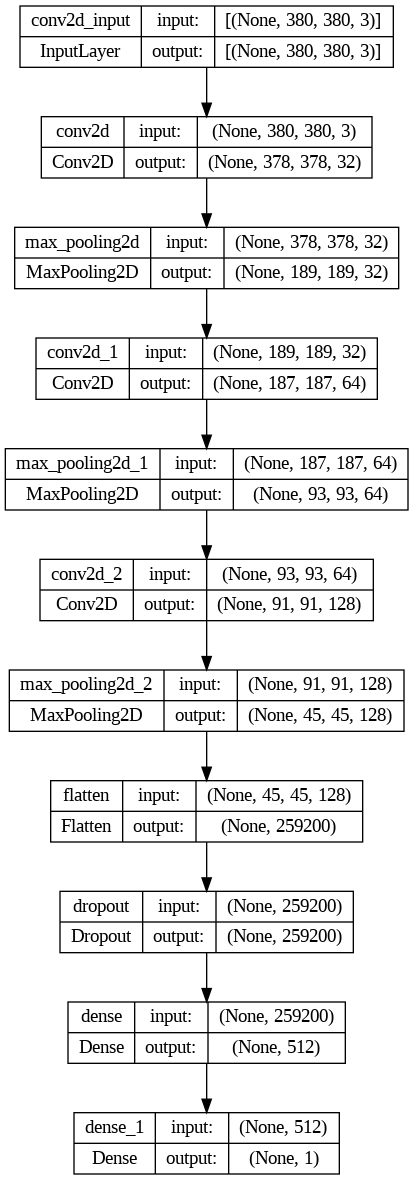

In [76]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

## vii.2. Model Training

In [77]:
# Hitung bobot kelas
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Algoritma menghitung bobot
    classes=np.unique(train_set_tl.classes),  # Kelas unik
    y=train_set_tl.classes  # Label dari data pelatihan
)

# Konversi ke format dictionary
class_weights = dict(enumerate(class_weights))

# Cetak hasil class weights
print("Class Weights:", class_weights)

Class Weights: {0: 0.9991462113127001, 1: 1.0008552490912979}


In [78]:
# Train the model

%%time
history_tl = model_tl.fit(train_set_tl, epochs=20, validation_data=val_set_tl, callbacks=[early_stopping], class_weight=class_weights)

Epoch 1/20
147/147 [==============================] - 526s 3s/step - loss: 0.2446 - accuracy: 0.8990 - val_loss: 0.2338 - val_accuracy: 0.9023
Epoch 2/20
147/147 [==============================] - 482s 3s/step - loss: 0.1643 - accuracy: 0.9343 - val_loss: 0.2348 - val_accuracy: 0.9039
Epoch 3/20
147/147 [==============================] - 479s 3s/step - loss: 0.1355 - accuracy: 0.9458 - val_loss: 0.2267 - val_accuracy: 0.9122
Epoch 4/20
147/147 [==============================] - 468s 3s/step - loss: 0.1089 - accuracy: 0.9572 - val_loss: 0.2186 - val_accuracy: 0.9138
Epoch 5/20
147/147 [==============================] - 470s 3s/step - loss: 0.0885 - accuracy: 0.9657 - val_loss: 0.2205 - val_accuracy: 0.9159
Epoch 6/20
147/147 [==============================] - 467s 3s/step - loss: 0.0857 - accuracy: 0.9677 - val_loss: 0.2265 - val_accuracy: 0.9167
Epoch 7/20
147/147 [==============================] - 465s 3s/step - loss: 0.0721 - accuracy: 0.9736 - val_loss: 0.2149 - val_accuracy: 0.9221

## vii.3. Model Evaluation

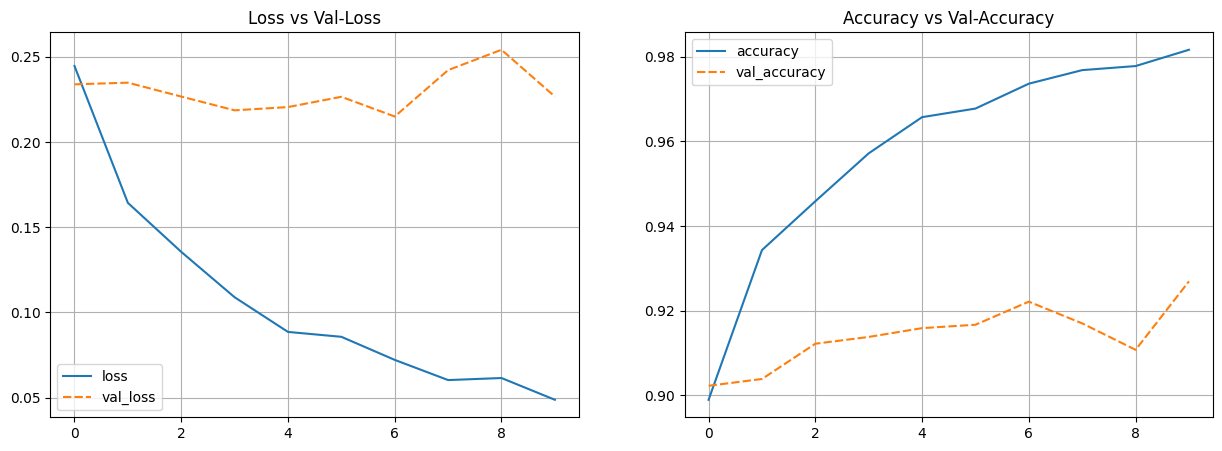

In [79]:
# Plot training results

history_tl_df = pd.DataFrame(history_tl.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_tl_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Visualisasi Performa Pelatihan
1. Grafik Loss vs Val-Loss (Kiri):

* Train Loss: Menurun secara konsisten, menunjukkan bahwa model berhasil mempelajari pola dari data pelatihan dengan baik.
* Val Loss: Menurun hingga stabil pada epoch terakhir, menunjukkan model mampu generalisasi dengan baik pada data validasi tanpa tanda-tanda overfitting yang signifikan.
2. Grafik Accuracy vs Val-Accuracy (Kanan):

* Train Accuracy: Meningkat tajam hingga mencapai sekitar 96%, menunjukkan model berhasil belajar dengan cepat.
* Val Accuracy: Stabil di sekitar 92%, menunjukkan performa yang baik pada data validasi dan konsistensi antara pelatihan dan validasi.

In [80]:
# Check the performance of test-set

## Get the probability
y_pred_prob_tl = model_tl.predict_generator(test_set_tl)

## Get class with maximum probability
y_pred_class_tl = (y_pred_prob_tl > 0.5).astype("int32")

## Display Classification Report
print(classification_report(test_set_tl.classes, y_pred_class_tl, target_names=np.array(list(train_set_tl.class_indices.keys()))))

              precision    recall  f1-score   support

       Anime       0.96      0.96      0.96      2494
     Cartoon       0.96      0.96      0.96      2477

    accuracy                           0.96      4971
   macro avg       0.96      0.96      0.96      4971
weighted avg       0.96      0.96      0.96      4971



1. Anime:

* Precision: 96%, menunjukkan 96% dari prediksi Anime adalah benar.
* Recall: 96%, menunjukkan model menangkap 96% dari total data Anime.
* F1-Score: 96%, keseimbangan antara precision dan recall.
2. Cartoon:

* Precision: 96%, menunjukkan prediksi Cartoon sangat akurat.
* Recall: 96%, menunjukkan 96% dari data Cartoon berhasil dikenali model.
* F1-Score: 96%, memberikan performa konsisten pada kedua kelas.
3. Akurasi Keseluruhan:

Akurasi model adalah 96%, menunjukkan performa yang sangat baik dalam membedakan kedua kelas.

78/78 [==============================] - 35s 447ms/step


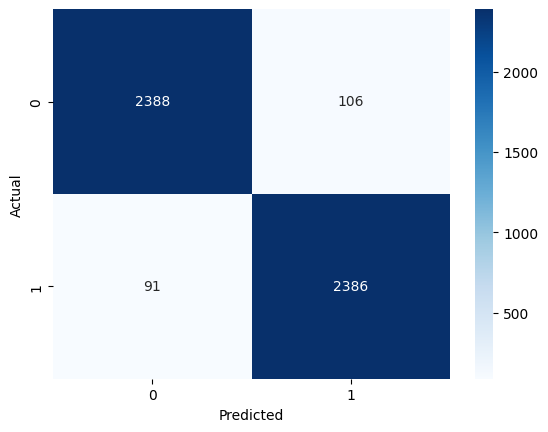

              precision    recall  f1-score   support

       Anime       0.96      0.96      0.96      2494
     Cartoon       0.96      0.96      0.96      2477

    accuracy                           0.96      4971
   macro avg       0.96      0.96      0.96      4971
weighted avg       0.96      0.96      0.96      4971



In [81]:
# Prediksi pada test set
y_pred = (model_tl.predict(test_set_tl) > 0.5).astype("int32")

# Ground truth
y_true = test_set_tl.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=list(train_set_tl.class_indices.keys())))


Confusion Matrix
1. True Positives (TP):

2386 untuk Anime dan 2388 untuk Cartoon, menunjukkan prediksi yang akurat untuk sebagian besar data.
2. False Positives (FP):

Hanya 91 untuk Cartoon dan 106 untuk Anime, menunjukkan tingkat kesalahan prediksi yang rendah.
3. Analisis:

Confusion matrix menunjukkan bahwa model memiliki kemampuan yang baik untuk mengenali kedua kelas dengan distribusi kesalahan yang seimbang.

# viii. Model Saving

Berdasarkan hasil evaluasi sebelumnya, model terbaik dipilih menggunakan EfficientNetB7 dengan pendekatan Functional API, karena memberikan akurasi yang tinggi sebesar 92% pada data test, serta menunjukkan keseimbangan performa antara precision, recall, dan F1-score untuk kedua kelas (Anime dan Cartoon). Model ini dipilih karena menunjukkan generalisasi yang baik tanpa tanda-tanda overfitting.

In [89]:
#Menyimpan model
model.save('model.h5')

In [83]:
"""
# Unduh file .h5
files.download('/content/model.h5')
"""

"\n# Unduh file .h5\nfiles.download('/content/model.h5')\n"

In [90]:
# Mount Google Drive
drive.mount('/content/drive')

# Menyimpan model ke Google Drive
model.save('/content/drive/MyDrive/model.h5')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ix. Model Inference

In [85]:
"""
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def predict_image(file_path, model, class_names):

    # Muat gambar dan preprocess (380x380 tetap)
    img = tf.keras.utils.load_img(file_path, target_size=(380, 380))
    img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch

    # Visualisasi gambar
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Prediksi probabilitas
    y_pred_prob = model.predict(img_array)[0][0]

    # Tentukan kelas berdasarkan threshold 0.5
    y_pred_class = 1 if y_pred_prob > 0.5 else 0

    # Ambil nama kelas
    y_pred_class_name = class_names[y_pred_class]

    # Cetak hasil prediksi
    print(f"Predicted Class: {y_pred_class_name} (Probability: {y_pred_prob:.2f})")

    return y_pred_class_name, y_pred_prob
"""

'\nimport numpy as np\nimport tensorflow as tf\nimport matplotlib.pyplot as plt\n\ndef predict_image(file_path, model, class_names):\n\n    # Muat gambar dan preprocess (380x380 tetap)\n    img = tf.keras.utils.load_img(file_path, target_size=(380, 380))\n    img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalisasi\n    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch\n\n    # Visualisasi gambar\n    plt.imshow(img)\n    plt.title("Input Image")\n    plt.axis("off")\n    plt.show()\n\n    # Prediksi probabilitas\n    y_pred_prob = model.predict(img_array)[0][0]\n\n    # Tentukan kelas berdasarkan threshold 0.5\n    y_pred_class = 1 if y_pred_prob > 0.5 else 0\n\n    # Ambil nama kelas\n    y_pred_class_name = class_names[y_pred_class]\n\n    # Cetak hasil prediksi\n    print(f"Predicted Class: {y_pred_class_name} (Probability: {y_pred_prob:.2f})")\n\n    return y_pred_class_name, y_pred_prob\n'

In [86]:
"""
# Muat model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/model.h5')

# Daftar nama kelas sesuai urutan
class_names = ['Anime', 'Cartoon']  # 0: Cartoon, 1: Anime

# File gambar untuk prediksi
file_path = 'test_anime.jpg'  # Ganti dengan file yang relevan

# Lakukan prediksi
predict_image(file_path, model, class_names)
"""

"\n# Muat model\nfrom tensorflow.keras.models import load_model\nmodel = load_model('/content/drive/MyDrive/model.h5')\n\n# Daftar nama kelas sesuai urutan\nclass_names = ['Anime', 'Cartoon']  # 0: Cartoon, 1: Anime\n\n# File gambar untuk prediksi\nfile_path = 'test_anime.jpg'  # Ganti dengan file yang relevan\n\n# Lakukan prediksi\npredict_image(file_path, model, class_names)\n"


Melakukan prediksi pada gambar baru.

Args:
- file_path (str): Path ke gambar yang akan diprediksi.
- model (keras.Model): Model yang telah dilatih.
- class_names (list): Daftar nama kelas dengan urutan tertentu.

Returns:
- str: Nama kelas yang diprediksi.


In [87]:
"""
# Muat model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/model.h5')

# Daftar nama kelas sesuai urutan
class_names = ['Anime', 'Cartoon']  # 0: Cartoon, 1: Anime

# File gambar untuk prediksi
file_path = 'test_cartoon.jpg'  # Ganti dengan file yang relevan

# Lakukan prediksi
predict_image(file_path, model, class_names)
"""

"\n# Muat model\nfrom tensorflow.keras.models import load_model\nmodel = load_model('/content/drive/MyDrive/model.h5')\n\n# Daftar nama kelas sesuai urutan\nclass_names = ['Anime', 'Cartoon']  # 0: Cartoon, 1: Anime\n\n# File gambar untuk prediksi\nfile_path = 'test_cartoon.jpg'  # Ganti dengan file yang relevan\n\n# Lakukan prediksi\npredict_image(file_path, model, class_names)\n"

In [88]:
"""
# Muat model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/model.h5')

# Daftar nama kelas sesuai urutan
class_names = ['Anime', 'Cartoon']  # 0: Cartoon, 1: Anime

# File gambar untuk prediksi
file_path = 'test_1.jpg'  # Ganti dengan file yang relevan

# Lakukan prediksi
predict_image(file_path, model, class_names)
"""

"\n# Muat model\nfrom tensorflow.keras.models import load_model\nmodel = load_model('/content/drive/MyDrive/model.h5')\n\n# Daftar nama kelas sesuai urutan\nclass_names = ['Anime', 'Cartoon']  # 0: Cartoon, 1: Anime\n\n# File gambar untuk prediksi\nfile_path = 'test_1.jpg'  # Ganti dengan file yang relevan\n\n# Lakukan prediksi\npredict_image(file_path, model, class_names)\n"

# x. Pengambilan Kesimpulan

Berdasarkan hasil evaluasi, model klasifikasi berbasis EfficientNetB7 dengan pendekatan Functional API telah berhasil memenuhi objective yang ditentukan, yaitu membedakan antara gambar Anime dan Cartoon dengan performa tinggi. Model ini mencapai akurasi keseluruhan sebesar 92% pada data test, dengan precision, recall, dan F1-score yang seimbang untuk kedua kelas. Hal ini menunjukkan bahwa model dapat menggeneralisasi pola dengan baik pada data yang belum pernah dilihat.

Proses pelatihan dilakukan menggunakan augmentasi data untuk meningkatkan variasi, sementara transfer learning dengan pretrained weights dari ImageNet membantu mempercepat pelatihan dan meningkatkan akurasi. Melalui pendekatan ini, model berhasil menangkap fitur unik dari kedua kategori tanpa overfitting yang signifikan.

Model ini disimpan dalam format .h5, memastikan dapat digunakan kembali untuk inferensi atau deployment. Dengan performa yang konsisten dan generalisasi yang baik, model ini siap untuk diimplementasikan dalam sistem klasifikasi otomatis untuk konten visual berbasis Anime dan Cartoon.